# <a id='toc1_'></a>[**Transfer Learning with TensorFlow Part 2 : Fine-Tuning**](#toc0_)

Reference: https://github.com/mrdbourke/tensorflow-deep-learning

In the previous notebook, we covered transfer learning feature extrction, now it's time to learn about a new kind of transfer learning: fine-tuning

**Table of contents**<a id='toc0_'></a>    
- [**Transfer Learning with TensorFlow Part 2 : Fine-Tuning**](#toc1_)    
  - [**Check your device and version**](#toc1_1_)    
  - [**Creating helper functions**](#toc1_2_)    
  - [**Let's get some data**](#toc1_3_)    
  - [**Model 0: Building a transfer learning feature extraction model using the Keras Functional API**](#toc1_4_)    
  - [**Getting a feature vector from a trained model**](#toc1_5_)    
  - [**Running a series of transfer learning experiments**](#toc1_6_)    
    - [**Getting and preprocessing data for model_1**](#toc1_6_1_)    
    - [**Adding data augmentation right into the model**](#toc1_6_2_)    
    - [Visualize our data augmentation layer (and see what happens to our data)](#toc1_6_3_)    
  - [**Model 1 : Feature extraction trasfer learning on 1% of the data with data augmentation**](#toc1_7_)    
  - [**Model 2 : Feature extraction trasfer learning on 10% of the data with data augmentation**](#toc1_8_)    
    - [**Creating a ModelCheckpoint callback**](#toc1_8_1_)    
    - [**Fit model 2 passing the the ModelCheckpoint callback**](#toc1_8_2_)    
    - [Losding in checkpointed weights](#toc1_8_3_)    
  - [**Model 3 : Fine-tuning an existing model on % of the data**](#toc1_9_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

<a id="1"></a>
## <a id='toc1_1_'></a>[**Check your device and version**](#toc0_)

In [431]:
# Add timestamp
import datetime
print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")

Notebook last run (end-to-end): 2023-05-27 23:55:00.306065


In [432]:
# Are we using a GPU?
!nvidia-smi

/bin/bash: /home/chioujryu/anaconda3/envs/tf_2.8.3__python_3.9/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Sat May 27 23:55:00 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.182.03   Driver Version: 470.182.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    Off  | 00000000:03:00.0 Off |                  Off |
| 30%   32C    P8    10W / 300W |  47880MiB / 48685MiB |      0%      Default |
|                               |                      |                  N/A |
+----------------------------

```
Tue May 23 09:26:34 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.182.03   Driver Version: 470.182.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    Off  | 00000000:03:00.0 Off |                  Off |
| 30%   31C    P8     8W / 300W |  47810MiB / 48685MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU   GI   CI        PID   Type   Process name                  GPU Memory |
|        ID   ID                                                   Usage      |
|=============================================================================|
|    0   N/A  N/A      1315      G   /usr/lib/xorg/Xorg                  4MiB |
|    0   N/A  N/A      9270      G   /usr/lib/xorg/Xorg                  4MiB |
|    0   N/A  N/A     15698      G   /usr/lib/xorg/Xorg                  4MiB |
|    0   N/A  N/A     51864    C+G   ...ome-remote-desktop-daemon      261MiB |
|    0   N/A  N/A     81175      C   ...11__python_3.9/bin/python    47531MiB |
+-----------------------------------------------------------------------------+
```

In [433]:
import os
print("posix = Linux, nt = windows, java = java")
print("your os name is",os.name)

import platform
print("your os is ",platform.system()+platform.release())

from platform import python_version
print("python version is",python_version())

import tensorflow as tf
print("TensorFlow version is",tf.__version__)

print("Are we using a GPU?",len(tf.config.experimental.list_physical_devices('GPU'))>0)

posix = Linux, nt = windows, java = java
your os name is posix
your os is  Linux5.19.0-42-generic
python version is 3.9.16
TensorFlow version is 2.8.3
Are we using a GPU? True


* posix = Linux, nt = windows, java = java
* your os name is posix
* your os is  Linux5.19.0-42-generic
* python version is 3.9.16
* TensorFlow version is 2.8.3
* Are we using a GPU? True

<a href="#toc" role="button" aria-pressed="true" >⬆️Back to Table of Contents ⬆️</a>

<a id="2"></a>
## <a id='toc1_2_'></a>[**Creating helper functions**](#toc0_)

In previous notebooks, we've created a bunch of helper functions, now we could rewrite them all, however, this is tedious.

So, it's a good idea to put functions you'll want to use again in a script you can download and import into your notebooks (or elsewhere).

We've done this for some of the functions we've used previously here: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [434]:
# for linux command
if os.path.exists("helper_functions.py") != True:
    !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# for windows command
# import wget
# if os.path.exists("helper_functions.py") != True:
#     wget.download('https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py')

In [435]:
# Import helper functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir, download_file


> 🔑**Note:** If you're running this notebook in Google Colab, when it times out Colab will delete `helper_functions.py`, so you'll have to redownload it if you want access to your helper functions.

## <a id='toc1_3_'></a>[**Let's get some data**](#toc0_)

This time we're going to see how we can use the pretrained models whithin `tf.keras.applications` and apply them to our own problem (recognizing images of food).

link: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [436]:
# Get 10% of training data of 10 classes of Food101

# for linux command
if os.path.exists("10_food_classes_10_percent.zip") != True:
    !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# # for windows
# import wget

# if os.path.exists("10_food_classes_10_percent.zip") != True:
#     wget.download('https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip')
#     print("Download Scucess")


unzip_data("10_food_classes_10_percent.zip")

/bin/bash: /home/chioujryu/anaconda3/envs/tf_2.8.3__python_3.9/lib/libtinfo.so.6: no version information available (required by /bin/bash)
--2023-05-27 23:55:01--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
正在查找主機 storage.googleapis.com (storage.googleapis.com)... 2404:6800:4012:1::2010, 2404:6800:4012:3::2010, 2404:6800:4012::2010, ...
正在連接 storage.googleapis.com (storage.googleapis.com)|2404:6800:4012:1::2010|:443... 連上了。
已送出 HTTP 要求，正在等候回應... 200 OK
長度: 168546183 (161M) [application/zip]
儲存到：‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  29.8MB/s    於 5.5s     

2023-05-27 23:55:07 (29.1 MB/s) - 已儲存 ‘10_food_classes_10_percent.zip’ [168546183/168546183]



In [437]:
# Clear any logs from previous runs
# 如果要刪除資料夾可以輸入這個指令
# !rm -rf ./10_food_classes_10_percent.zip/ # linux
# !rd /s /q 10_food_classes_10_percent.zip  # windows

# # 如果要刪除檔案可以輸入這個指令
# # for windows
# !del /s /q "10_food_classes_10_percent.zip"

# for linux
!rm -rf 10_food_classes_10_percent.zip

/bin/bash: /home/chioujryu/anaconda3/envs/tf_2.8.3__python_3.9/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [438]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [439]:
# Create training and test directory paths

train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [440]:
IMG_SIZE = (224,224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.utils.image_dataset_from_directory(
                                        directory = train_dir,
                                        labels='inferred',
                                        label_mode='categorical',
                                        class_names=None,
                                        color_mode='rgb',
                                        batch_size = BATCH_SIZE,
                                        image_size = IMG_SIZE,
                                        shuffle=True,
                                        seed=None,
                                        validation_split=None,
                                        subset=None,
                                        interpolation='bilinear',
                                        follow_links=False,
                                        crop_to_aspect_ratio=False,
                                    )


test_data = tf.keras.utils.image_dataset_from_directory(
                                        directory = test_dir,
                                        labels='inferred',
                                        label_mode='categorical',
                                        class_names=None,
                                        color_mode='rgb',
                                        batch_size = BATCH_SIZE,
                                        image_size = IMG_SIZE,
                                        shuffle=True,
                                        seed=None,
                                        validation_split=None,
                                        subset=None,
                                        interpolation='bilinear',
                                        follow_links=False,
                                        crop_to_aspect_ratio=False,
                                    )


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [441]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [442]:
# Check out the class name of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [443]:
# See an example of a batch of data
for images, labels in train_data_10_percent.take(1):
    tf.print(images,labels)

[[[[163.887756 165.887756 144.887756]
   [180.38266 179.38266 159.38266]
   [159.581635 162.795914 145.663269]
   ...
   [138.356964 142.928436 137.275421]
   [123.331627 129.545959 127.47451]
   [120.596802 130.183563 129.183563]]

  [[169.051025 168.051025 150.051025]
   [182.280624 181.280624 161.280624]
   [165.81633 169.030609 152.658173]
   ...
   [139.300888 141.285599 135.999908]
   [117.556183 121.847031 120.704155]
   [118.3619 125.571182 125.168091]]

  [[163.005112 161.576538 143.790817]
   [178.515305 177.484695 159.5]
   [158.908157 161.122452 147.765305]
   ...
   [140.887711 141.459183 136.459183]
   [127.321396 129.479584 126.576546]
   [123.515221 128.076508 128.367294]]

  ...

  [[89.0663528 43.0663567 19.0663567]
   [87.2703857 41.2703857 17.2703876]
   [87.1683273 41.1683273 17.1683273]
   ...
   [165.091812 103.09182 26.0918179]
   [161.775528 99.7755203 22.7755241]
   [166.2603 104.260292 27.2602921]]

  [[88.2142563 42.2142601 18.2142601]
   [86.9948959 40.9948

## <a id='toc1_4_'></a>[**Model 0: Building a transfer learning feature extraction model using the Keras Functional API**](#toc0_)

The sequential API is straight-forward, it runs our layers in sequential order

But the functional API gives us more flexibility with our models - https://www.tensorflow.org/guide/keras/functional

In [444]:
# 1. Create base model with tf.keras.app
base_model = tf.keras.applications.EfficientNetB0(include_top=False)    # model is in user/user/.keras/models

# 2. Freeze the base model (so the underlying pre-trained patterns are not update during training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")

# 4. If using a model like ResNet50V2 you will need to normalize inputs
# (you don't have to for EfficientNet(s), because there is rescaling layer in EfficientNet model)
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model:{x.shape}")

# 6. Average pool the outputs of the base model(aggregate all the most important information, reduce number of computations)
# If it's just a layer, x will be placed at the very side, but if it's a sequential model, 
# x will be placed inside the brackets.
x = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D:{x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10,activation = "softmax", name = "output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss="categorical_crossentropy", 
                optimizer=tf.keras.optimizers.Adam(), 
                metrics=["accuracy"])

# 10. Fit the model and save its history
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs = 5,
                                 steps_per_epoch = len(train_data_10_percent),
                                 validation_data = test_data,
                                 validation_steps = int(0.25 * len(test_data)), # Only 25% of the test data is used because using 100% of the test data for each epoch would take too long.
                                 callbacks=[create_tensorboard_callback(dir_name ="transfer_learning",experiment_name = "10_percent_feature_extraction")])


Shape after passing inputs through base model:(None, 7, 7, 1280)
Shape after GlobalAveragePooling2D:(None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20230527-235515
Epoch 1/5
24/24 [==============================] - 4s 82ms/step - loss: 1.9458 - accuracy: 0.3933 - val_loss: 1.4226 - val_accuracy: 0.6612
Epoch 2/5
24/24 [==============================] - 2s 64ms/step - loss: 1.1534 - accuracy: 0.7347 - val_loss: 0.9579 - val_accuracy: 0.7763
Epoch 3/5
24/24 [==============================] - 2s 65ms/step - loss: 0.8412 - accuracy: 0.8027 - val_loss: 0.7713 - val_accuracy: 0.8158
Epoch 4/5
24/24 [==============================] - 2s 61ms/step - loss: 0.6881 - accuracy: 0.8400 - val_loss: 0.6532 - val_accuracy: 0.8257
Epoch 5/5
24/24 [==============================] - 2s 63ms/step - loss: 0.5912 - accuracy: 0.8587 - val_loss: 0.6379 - val_accuracy: 0.8207


In [445]:
model_0.evaluate(test_data)

79/79 [==============================] - 3s 35ms/step - loss: 0.6130 - accuracy: 0.8336


[0.612957239151001, 0.8335999846458435]

In [446]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number,layer.name)

0 input_21
1 rescaling_20
2 normalization_20
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3

In [447]:
# How about we get a summary of the base model?

base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_20 (Rescaling)       (None, None, None,   0           ['input_21[0][0]']               
                                3)                                                                
                                                                                                  
 normalization_20 (Normalizatio  (None, None, None,   7          ['rescaling_20[0][0]']           
 n)                             3)                                                   

In [448]:
# How about we get a summary of our whole model?

model_0.summary()

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


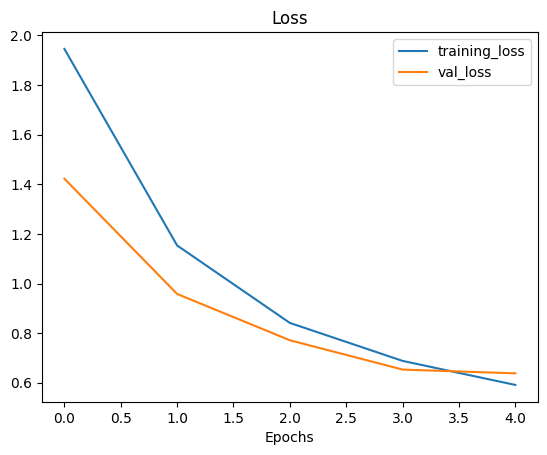

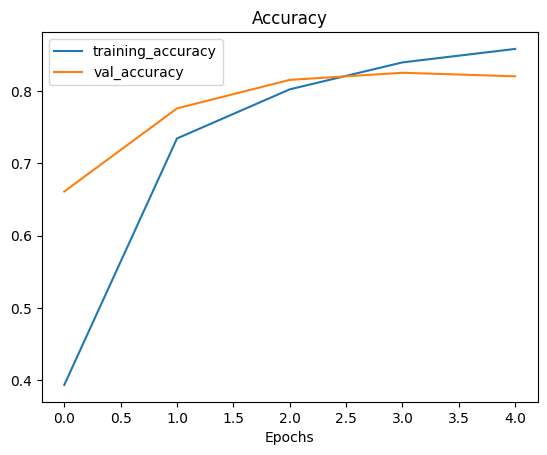

In [449]:
# Check out our model's training cureve

plot_loss_curves(history_10_percent)

## <a id='toc1_5_'></a>[**Getting a feature vector from a trained model**](#toc0_)

Let's demonstrate the Golbal Average Pooling 2D Layer.

We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 1280).

But then when it passes through GlobalAveragePooling2D, it truns into (None, 1280).

Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass it to GlobalAveragePooling2D.

In [450]:
# Define the input shape
input_shape = (1,2,2,3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n{input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n{global_average_pooled_tensor}\n")


# Check the shape of the different tensors
print(f"Shape of input tensor:{input_tensor.shape}")
print(f"Shape of input tensor:{global_average_pooled_tensor.shape}")

Random input tensor:
[[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]]

  [[-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]]]

2D global average pooled random tensor:
[[-0.3371175  -1.0493976   0.17876767]]

Shape of input tensor:(1, 2, 2, 3)
Shape of input tensor:(1, 3)


In [451]:
# Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis = [1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.3371175 , -1.0493976 ,  0.17876767]], dtype=float32)>

經過了2D global average pooled 其實就是feature extraction，AI會知道每個數值代表的意思

>🛠 **Practice:** Try to do the same with the above two cells but this time use `GlobalMaxPool2D`... and see what happens

In [452]:
# 1. Create base model with tf.keras.app
base_model = tf.keras.applications.EfficientNetB0(include_top=False)    # model is in user/user/.keras/models

# 2. Freeze the base model (so the underlying pre-trained patterns are not update during training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")

# 4. If using a model like ResNet50V2 you will need to normalize inputs
# (you don't have to for EfficientNet(s), because there is rescaling layer in EfficientNet model)
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model:{x.shape}")

# 6. max pool the outputs of the base model(aggregate all the most important information, reduce number of computations)
# If it's just a layer, x will be placed at the very side, but if it's a sequential model, 
# x will be placed inside the brackets.
x = tf.keras.layers.GlobalMaxPool2D(name = "global_max_pooling_layer")(x)
print(f"Shape after GlobalMaxPool2D:{x.shape}")


x = tf.keras.layers.Dense(2048,activation = "relu", name = "fully_connection_1")(x)


# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10,activation = "softmax", name = "output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss="categorical_crossentropy", 
                optimizer=tf.keras.optimizers.Adam(), 
                metrics=["accuracy"])

# 10. Fit the model and save its history
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs = 5,
                                 steps_per_epoch = len(train_data_10_percent),
                                 validation_data = test_data,
                                 validation_steps = int(0.25 * len(test_data)), # Only 25% of the test data is used because using 100% of the test data for each epoch would take too long.
                                 callbacks=[create_tensorboard_callback(dir_name ="transfer_learning",experiment_name = "10_percent_feature_extraction")])


Shape after passing inputs through base model:(None, 7, 7, 1280)
Shape after GlobalMaxPool2D:(None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20230527-235529
Epoch 1/5
24/24 [==============================] - 4s 80ms/step - loss: 12.8777 - accuracy: 0.3067 - val_loss: 1.6488 - val_accuracy: 0.5987
Epoch 2/5
24/24 [==============================] - 2s 62ms/step - loss: 1.0594 - accuracy: 0.7013 - val_loss: 1.0431 - val_accuracy: 0.6809
Epoch 3/5
24/24 [==============================] - 2s 64ms/step - loss: 0.5511 - accuracy: 0.8320 - val_loss: 0.8033 - val_accuracy: 0.7730
Epoch 4/5
24/24 [==============================] - 2s 63ms/step - loss: 0.3191 - accuracy: 0.9013 - val_loss: 0.5720 - val_accuracy: 0.8158
Epoch 5/5
24/24 [==============================] - 2s 62ms/step - loss: 0.1603 - accuracy: 0.9587 - val_loss: 0.6239 - val_accuracy: 0.8109


## <a id='toc1_6_'></a>[**Running a series of transfer learning experiments**](#toc0_)

We've seen the incredible results transfer learning can get with only 10% of the training data, but how does it go with 1% of the raining data... how about we set up a bunch of experiments to find out:

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation
2. `model_2` - use feature extraction trasfer learning with 10% of the training with data augmentation
3. `model_3` - use fine-tunning transfer learning on 10% of the training data with data augmentation
4. `model_4` - use fine-tuning transfer learning on 100% of the training data with data augmentation

> 🔑**Note:** throughout all experiments the same test dataset will be used to evaluate our model...this ensures consistency across

### <a id='toc1_6_1_'></a>[**Getting and preprocessing data for model_1**](#toc0_)

In [453]:
# Download and unzip data

# for linux command
if os.path.exists("10_food_classes_1_percent.zip") != True:
    !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

# for windows command
# if os.path.exists("10_food_classes_1_percent.zip") != True:
#     wget.download('https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip')

unzip_data("10_food_classes_1_percent.zip")

/bin/bash: /home/chioujryu/anaconda3/envs/tf_2.8.3__python_3.9/lib/libtinfo.so.6: no version information available (required by /bin/bash)
--2023-05-27 23:55:39--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
正在查找主機 storage.googleapis.com (storage.googleapis.com)... 2404:6800:4012:2::2010, 2404:6800:4012::2010, 2404:6800:4012:3::2010, ...
正在連接 storage.googleapis.com (storage.googleapis.com)|2404:6800:4012:2::2010|:443... 連上了。
已送出 HTTP 要求，正在等候回應... 200 OK
長度: 133612354 (127M) [application/zip]
儲存到：‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  31.7MB/s    於 3.8s     

2023-05-27 23:55:43 (33.9 MB/s) - 已儲存 ‘10_food_classes_1_percent.zip’ [133612354/133612354]



In [454]:
# Clear any logs from previous runs
# 如果要刪除資料夾可以輸入這個指令
# !rm -rf ./10_food_classes_1_percent.zip/ # linux
# !rd /s /q 10_food_classes_1_percent.zip  # windows

# # 如果要刪除檔案可以輸入這個指令
# # for windows
# !del /s /q "10_food_classes_1_percent.zip"

# for linux
!rm -rf 10_food_classes_1_percent.zip

/bin/bash: /home/chioujryu/anaconda3/envs/tf_2.8.3__python_3.9/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [455]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'

In [456]:
# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [457]:
# Setup data loaders
IMG_SIZE = (224,224)
BATCH_SIZE = 32
train_data_1_percent = tf.keras.utils.image_dataset_from_directory(
                                        directory = train_dir_1_percent,
                                        labels='inferred',
                                        label_mode='categorical',
                                        class_names=None,
                                        color_mode='rgb',
                                        batch_size = BATCH_SIZE,
                                        image_size = IMG_SIZE,
                                        shuffle=True,
                                        seed=None,
                                        validation_split=None,
                                        subset=None,
                                        interpolation='bilinear',
                                        follow_links=False,
                                        crop_to_aspect_ratio=False,
                                    )

test_data = tf.keras.utils.image_dataset_from_directory(
                                        directory = test_dir,
                                        labels='inferred',
                                        label_mode='categorical',
                                        class_names=None,
                                        color_mode='rgb',
                                        batch_size = BATCH_SIZE,
                                        image_size = IMG_SIZE,
                                        shuffle=True,
                                        seed=None,
                                        validation_split=None,
                                        subset=None,
                                        interpolation='bilinear',
                                        follow_links=False,
                                        crop_to_aspect_ratio=False,
                                    )

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


### <a id='toc1_6_2_'></a>[**Adding data augmentation right into the model**](#toc0_)

To add data augmentation right into our models, we can use the layers inside:

* `tf.keras.layers()` - https://www.tensorflow.org/api_docs/python/tf/keras/layers

We can see the benefits of doing this within the TensorFlow Data augmentation documentation: https://www.tensorflow.org/tutorials/images/data_augmentation#two_options_to_use_the_keras_preprocessing_layers

Off the top our of head, after reading the docs, after reading the docs, the benefits of using data augmentation inside the model are:
* Preprocessing of images (augmenting them) happens on the GPU (much faster) rather than the CPU
* Image data augmentation only happens during training, so we can still export our whole model and use it elsewhere.
* If you use [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator), you will use CPU to generate your data.

In [458]:
# Create data augmentation stage with horizontal flipping, rotations, zooms, etc...
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomWidth(0.2), 
    #tf.keras.layers.Rescaling(scale=1./255), # keep for models like ResNet50V2 but EfficientNet's having rescaling built-in
],name = "data_augmentation")

### <a id='toc1_6_3_'></a>[Visualize our data augmentation layer (and see what happens to our data)](#toc0_)



In [459]:
# check the class names
train_data_1_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

10_food_classes_1_percent/train/grilled_salmon
[[[ 27   9   7]
  [ 28  10   8]
  [ 28  10   8]
  ...
  [ 76  12  12]
  [ 74  14  14]
  [ 78  20  19]]

 [[ 27   9   7]
  [ 27   9   7]
  [ 28  10   8]
  ...
  [ 73  12  11]
  [ 73  13  13]
  [ 75  19  18]]

 [[ 24   9   6]
  [ 25  10   7]
  [ 26  11   8]
  ...
  [ 71  11  10]
  [ 70  12  11]
  [ 70  16  14]]

 ...

 [[123 108  51]
  [122 109  56]
  [111  98  54]
  ...
  [ 19  22  29]
  [ 18  21  28]
  [ 26  29  36]]

 [[125 109  47]
  [122 107  48]
  [113 100  48]
  ...
  [ 13  16  23]
  [ 15  18  25]
  [ 28  31  36]]

 [[106  91  26]
  [117 103  42]
  [117 102  47]
  ...
  [ 24  27  34]
  [ 45  48  53]
  [ 74  77  82]]]
tf.Tensor(
[[[ 20.982355   27.771315   46.771317 ]
  [ 20.474152   27.438652   46.438656 ]
  [ 21.348011   28.347439   47.347443 ]
  ...
  [221.96437   164.84993    57.319023 ]
  [227.84535   169.75986    63.099804 ]
  [243.0369    185.13431    79.52064  ]]

 [[ 23.028854   28.91854    47.88255  ]
  [ 22.28649    29.02837

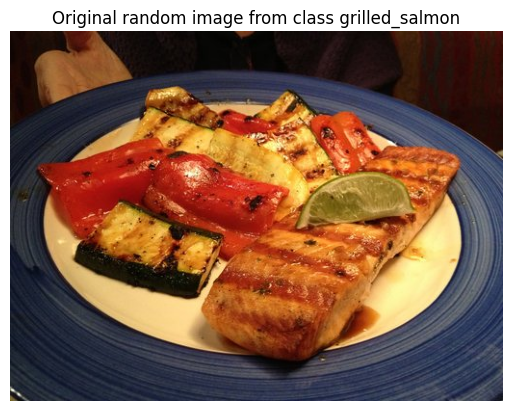

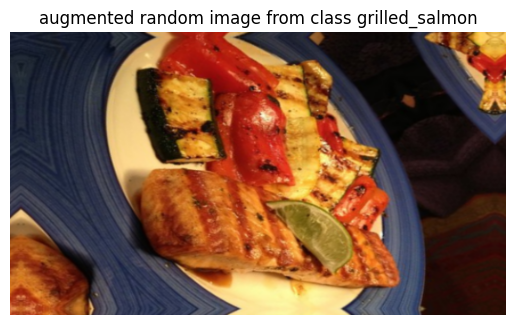

In [460]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os 
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
print(target_dir)
random_image = random.choice(os.listdir(target_dir))
randim_image_path = target_dir + '/' + random_image

# Read in the random image
img = mpimg.imread(randim_image_path)
print(img)
plt.axis(False)
plt.title(f"Original random image from class {target_class}")
plt.imshow(img)

# Now let's plot our augmented random image
augmented_image = data_augmentation(img, training = True)
print(augmented_image)
plt.figure()
plt.axis(False)
plt.title(f"augmented random image from class {target_class}")
plt.imshow(augmented_image.numpy().astype(int))


(182, 207, 3)
(199, 260, 3)
(264, 233, 3)
(245, 248, 3)
(227, 229, 3)
(194, 228, 3)
(210, 189, 3)
(183, 235, 3)
(265, 208, 3)


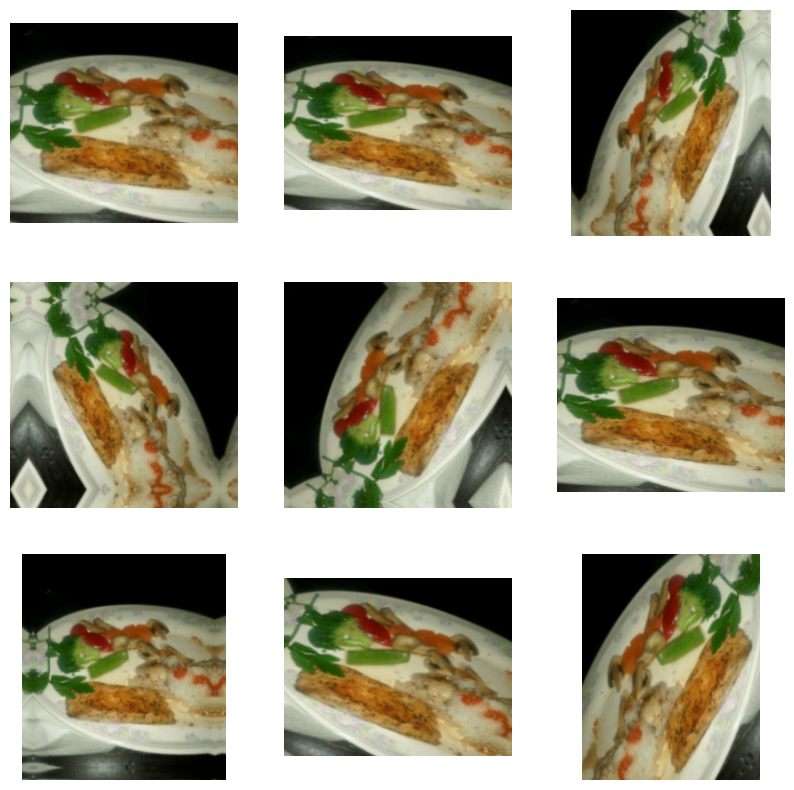

In [461]:
# 也可以一次做資料擴增好幾張
for image, _ in train_data_1_percent.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(first_image,training = True)   # 如果需要增加維度，可以寫 `tf.expand_dims(img, 0).shape`
    print(augmented_image.shape)
    plt.imshow(augmented_image / 255) 
    plt.axis('off')

## <a id='toc1_7_'></a>[**Model 1 : Feature extraction trasfer learning on 1% of the data with data augmentation**](#toc0_)

In [462]:
tf.keras.Input

<function keras.engine.input_layer.Input(shape=None, batch_size=None, name=None, dtype=None, sparse=None, tensor=None, ragged=None, type_spec=None, **kwargs)>

In [463]:
# Setup input shape and base model, freezing the base model layer

input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)    # model is in user/user/.keras/models
base_model.trainable = False

# Create input layer
inputs = tf.keras.layers.Input(shape = input_shape, name = "input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the input (after augmentation) and don't train it
x = base_model(x, training=False)    # Very similar with `base_model.trainable = False`, jsut rewrite it down here

# Pool output feature of the base 
# If it's just a layer, x will be placed at the very side, but if it's a sequential model, 
# x will be placed inside the brackets.
x = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)

# Put a dnese layer on as the output
outputs = tf.keras.layers.Dense(10, activation="softmax", name = "output_layer")(x)

# Make a model using the inputs and output
model_1 = tf.keras.Model(inputs, outputs)

# Compile the model 
model_1.compile(loss="categorical_crossentropy", 
                optimizer=tf.keras.optimizers.Adam(), 
                metrics=["accuracy"])

# Fit the model and save its history
history_1_percent = model_1.fit(train_data_1_percent,
                                 epochs = 10,
                                 steps_per_epoch = len(train_data_1_percent),
                                 validation_data = test_data,
                                 validation_steps = int(0.25 * len(test_data)), # Only 25% of the test data is used because using 100% of the test data for each epoch would take too long.
                                 callbacks=[create_tensorboard_callback(dir_name ="transfer_learning",experiment_name = "1_percent_data_augmentation")])



Saving TensorBoard log files to: transfer_learning/1_percent_data_augmentation/20230527-235550
Epoch 1/10
3/3 [==============================] - 3s 628ms/step - loss: 2.4070 - accuracy: 0.1000 - val_loss: 2.2100 - val_accuracy: 0.1579
Epoch 2/10
3/3 [==============================] - 1s 363ms/step - loss: 2.1254 - accuracy: 0.2000 - val_loss: 2.1207 - val_accuracy: 0.2270
Epoch 3/10
3/3 [==============================] - 1s 362ms/step - loss: 1.9429 - accuracy: 0.3857 - val_loss: 2.0216 - val_accuracy: 0.2911
Epoch 4/10
3/3 [==============================] - 1s 367ms/step - loss: 1.7713 - accuracy: 0.4857 - val_loss: 1.9309 - val_accuracy: 0.3388
Epoch 5/10
3/3 [==============================] - 1s 373ms/step - loss: 1.5665 - accuracy: 0.7143 - val_loss: 1.8357 - val_accuracy: 0.3964
Epoch 6/10
3/3 [==============================] - 1s 391ms/step - loss: 1.5045 - accuracy: 0.7000 - val_loss: 1.7854 - val_accuracy: 0.4359
Epoch 7/10
3/3 [==============================] - 1s 382ms/step -

In [464]:
# Check out a model summary

model_1.summary()

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, 3)          0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-train

In [465]:
# Evuluate all test dataset
model_1.evaluate(test_data)

79/79 [==============================] - 3s 35ms/step - loss: 1.5085 - accuracy: 0.5684


[1.5084760189056396, 0.5684000253677368]

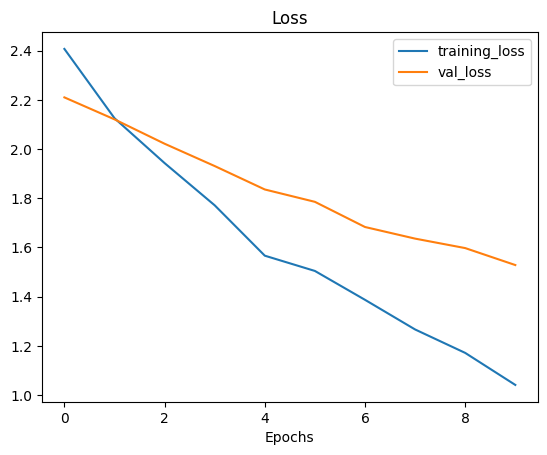

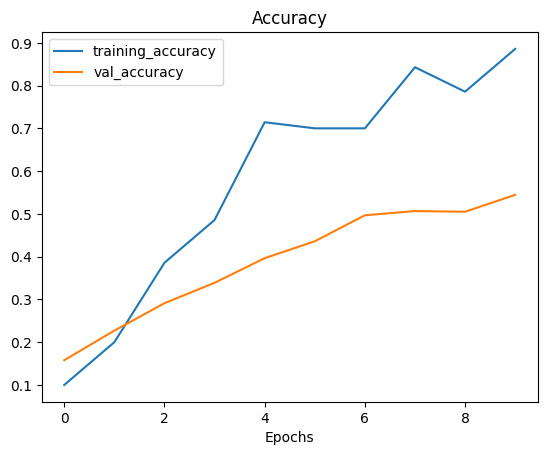

In [466]:
# How do the model with 1% of the and data augmentation loss curves look?

plot_loss_curves(history_1_percent)

## <a id='toc1_8_'></a>[**Model 2 : Feature extraction trasfer learning on 10% of the data with data augmentation**](#toc0_)

In [467]:
# get 10% of data (uncomment if you don't have it)

train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [468]:
# Set data inputs
import tensorflow as tf
IMG_SIZE = (224,224)

train_data_10_percent = tf.keras.utils.image_dataset_from_directory(
                                        directory = train_dir_10_percent,
                                        labels='inferred',
                                        label_mode='categorical',
                                        class_names=None,
                                        color_mode='rgb',
                                        batch_size = BATCH_SIZE,
                                        image_size = IMG_SIZE,
                                        shuffle=True,
                                        seed=None,
                                        validation_split=None,
                                        subset=None,
                                        interpolation='bilinear',
                                        follow_links=False,
                                        crop_to_aspect_ratio=False,
                                    )


test_data = tf.keras.utils.image_dataset_from_directory(
                                        directory = test_dir,
                                        labels='inferred',
                                        label_mode='categorical',
                                        class_names=None,
                                        color_mode='rgb',
                                        batch_size = BATCH_SIZE,
                                        image_size = IMG_SIZE,
                                        shuffle=True,
                                        seed=None,
                                        validation_split=None,
                                        subset=None,
                                        interpolation='bilinear',
                                        follow_links=False,
                                        crop_to_aspect_ratio=False,
                                    )


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [469]:
# How many images are in our directory
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [470]:
# check the file structure
import os

def list_files(startpath, show_file = False):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        if show_file == True:
            for f in files:
                print('{}{}'.format(subindent, f))

list_files("10_food_classes_10_percent", show_file = False)

10_food_classes_10_percent/
    test/
        chicken_wings/
        fried_rice/
        sushi/
        steak/
        ramen/
        chicken_curry/
        grilled_salmon/
        hamburger/
        ice_cream/
        pizza/
    train/
        chicken_wings/
        fried_rice/
        sushi/
        steak/
        ramen/
        chicken_curry/
        grilled_salmon/
        hamburger/
        ice_cream/
        pizza/


In [471]:
# Create model 2 with data augmentation built in

# Build data augmentation layer
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomWidth(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomRotation(0.2),
    # tf.keras.layers.Rescaling(scale=1./255) # if you are using a model such as ResNet,  you'll need to rescale your data, efficientnet has rescaling built-in
], name= "data_augmentation")

# Setup the input shape to our model
input_shape = (224,224,3)

# Create a fronzen base model (alse called the backbone)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the inputs and outputs (including the layers in between)
inputs = tf.keras.layers.Input(shape = input_shape, name = "input_layer")
x = data_augmentation(inputs, training = True)   # augment our training image (augmentation doesn't occur on test data)

# pass augmented image to base model but keep it in inference mode, this also insures BatchNormalization layers don't get updated
# https://keras.io/guides/transfer_learning/#build-a-model
x = base_model(x, training = False) 

x = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_pooling_2D")(x)
outputs = tf.keras.layers.Dense(10, activation="softmax", name = "output_layer")(x)

model_2 = tf.keras.Model(inputs, outputs)

# Compile
model_2.compile(loss = "categorical_crossentropy",
                   optimizer = tf.keras.optimizers.Adam(),
                   metrics=["accuracy"])

In [472]:
# from top to bottom: input_layer -> data_augmentation -> EfficientNetB0. 
# The input_layer serves as the input to the data_augmentation layer, 
# and the output of data_augmentation is then passed to the EfficientNetB0 model.
model_2.summary()

Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_2D (  (None, 1280)             0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-train

### <a id='toc1_8_1_'></a>[**Creating a ModelCheckpoint callback**](#toc0_)

The ModelCheckpoint callback intermediately saves our model(the full model or just the weight)

In [473]:
# set checkpoint path
checkpoint_path = "10_percent_model_checkpoint_weights/checkpoint.ckpt"

# create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                                            filepath = checkpoint_path,
                                                            monitor = 'val_loss',
                                                            verbose = 1,
                                                            save_best_only = False,
                                                            save_weights_only = True,
                                                            mode = 'auto',
                                                            save_freq='epoch',  # save every epoch
                                                            options=None,
                                                            initial_value_threshold=None,
                                                        )


### <a id='toc1_8_2_'></a>[**Fit model 2 passing the the ModelCheckpoint callback**](#toc0_)

In [474]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5

# Fit the model and save its history
history_10_percent_data_augmentation = model_2.fit(train_data_10_percent,
                                        epochs = initial_epochs,
                                        steps_per_epoch = len(train_data_10_percent),
                                        validation_data = test_data,
                                        validation_steps = int(0.25 * len(test_data)), # Only 25% of the test data is used because using 100% of the test data for each epoch would take too long.
                                        callbacks=[create_tensorboard_callback(dir_name ="transfer_learning",experiment_name = "10_percent_data_augmentation"),
                                                   checkpoint_callback ])  # 


Saving TensorBoard log files to: transfer_learning/10_percent_data_augmentation/20230527-235607
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0483 - accuracy: 0.3027
Epoch 1: saving model to 10_percent_model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 4s 109ms/step - loss: 2.0483 - accuracy: 0.3027 - val_loss: 1.6081 - val_accuracy: 0.5987
Epoch 2/5
23/24 [===========================>..] - ETA: 0s - loss: 1.4045 - accuracy: 0.6427
Epoch 2: saving model to 10_percent_model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 2s 86ms/step - loss: 1.4012 - accuracy: 0.6413 - val_loss: 1.2257 - val_accuracy: 0.6891
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0764 - accuracy: 0.7080
Epoch 3: saving model to 10_percent_model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 2s 82ms/step - loss: 1.0764 - accuracy: 0.7080 - val_loss: 1.0059 - val_accuracy: 0.7286
Epo

In [475]:
# what were model_0 results?

model_0.evaluate(test_data)


79/79 [==============================] - 3s 35ms/step - loss: 0.5779 - accuracy: 0.8184


[0.5778861045837402, 0.8184000253677368]

In [476]:
# Check model_2 results on all test_data
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 3s 42ms/step - loss: 0.8388 - accuracy: 0.7680


[0.8387854695320129, 0.7680000066757202]

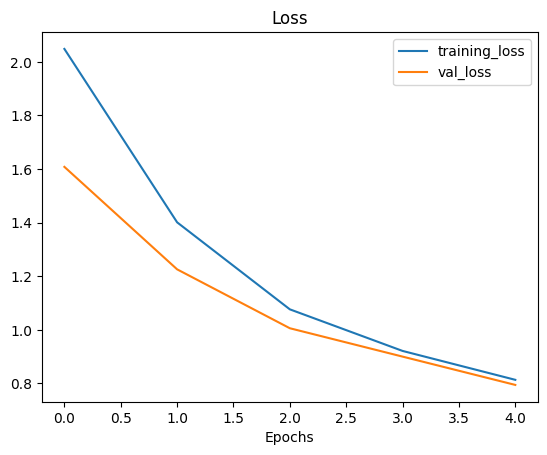

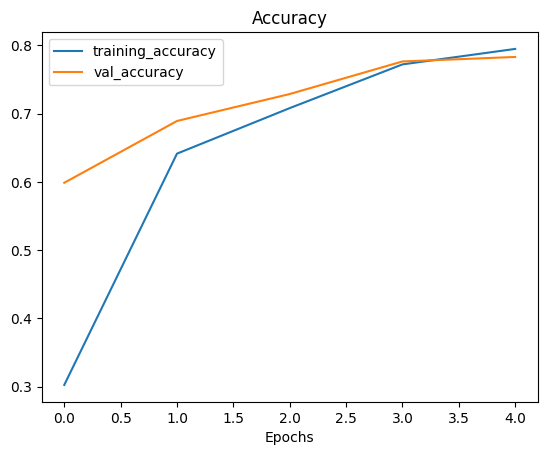

In [477]:
# Plot model loss curves
plot_loss_curves(history_10_percent_data_augmentation)

### <a id='toc1_8_3_'></a>[Losding in checkpointed weights](#toc0_)

Loading in checkpointed weights returns a model to a specific checkpoint.

In [478]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [479]:
# Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 3s 42ms/step - loss: 0.8392 - accuracy: 0.7692


In [480]:
# If the results from our previously evaluated model_2 match the loaded weights, everything has worked!
results_10_percent_data_aug == loaded_weights_model_results

False

In [481]:
# Check to see if loaded model results are very close to our previous non-laoded model results
import numpy as np
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([False, False])

In [482]:
# Check the difference between the two results
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[-0.00037616 -0.00120002]


## <a id='toc1_9_'></a>[**Model 3 : Fine-tuning an existing model on % of the data**](#toc0_)

> 🔑**Note:** Fine-tuning usually works best after training a feature extraction model for a few epochs with large amounts of custom data

Check which layer is untrainable

In [483]:
# Layers in loaded model
model_2.layers

In [484]:
for layer in model_2.layers:
    print(layer,layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fa7ddd83bb0> True
<keras.engine.sequential.Sequential object at 0x7fa7f54e19d0> True
<keras.engine.functional.Functional object at 0x7fa72507a400> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7fa724fabf70> True
<keras.layers.core.dense.Dense object at 0x7fa725001ee0> True


In [485]:
for i, layer in enumerate(model_2.layers[2].layers) :
    print(i, layer, layer.trainable)

0 <keras.engine.input_layer.InputLayer object at 0x7fa7ddd834c0> False
1 <keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7fa725408f70> False
2 <keras.layers.preprocessing.normalization.Normalization object at 0x7fa725408d30> False
3 <keras.layers.convolutional.ZeroPadding2D object at 0x7fa7254a33d0> False
4 <keras.layers.convolutional.Conv2D object at 0x7fa7de2b3430> False
5 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fa7dff0bc70> False
6 <keras.layers.core.activation.Activation object at 0x7fa7de14f6a0> False
7 <keras.layers.convolutional.DepthwiseConv2D object at 0x7fa7dff0bd00> False
8 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fa730467550> False
9 <keras.layers.core.activation.Activation object at 0x7fa7dff0bbe0> False
10 <keras.layers.pooling.GlobalAveragePooling2D object at 0x7fa7dff008b0> False
11 <keras.layers.core.reshape.Reshape object at 0x7fa725380b50> False
12 <keras.layers.convo

In [486]:
# How many trainable variables are in our base model?
print(len(model_2.layers[2].trainable_variables))

0


In [487]:
# To begin fine-tuning, let's start by setting the last 10 layers of our base_model.trainable = True
base_model.trainable = True

# Unfreeze layers for the last 10 layers
for layer in base_model.layers[:-10]:
    layer.trainable = False 

In [488]:
# check which layers are tunable (trainable)
for i, layer in enumerate(base_model.layers) :
    print(i, layer, layer.trainable)

0 <keras.engine.input_layer.InputLayer object at 0x7fa7ddd834c0> False
1 <keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7fa725408f70> False
2 <keras.layers.preprocessing.normalization.Normalization object at 0x7fa725408d30> False
3 <keras.layers.convolutional.ZeroPadding2D object at 0x7fa7254a33d0> False
4 <keras.layers.convolutional.Conv2D object at 0x7fa7de2b3430> False
5 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fa7dff0bc70> False
6 <keras.layers.core.activation.Activation object at 0x7fa7de14f6a0> False
7 <keras.layers.convolutional.DepthwiseConv2D object at 0x7fa7dff0bd00> False
8 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fa730467550> False
9 <keras.layers.core.activation.Activation object at 0x7fa7dff0bbe0> False
10 <keras.layers.pooling.GlobalAveragePooling2D object at 0x7fa7dff008b0> False
11 <keras.layers.core.reshape.Reshape object at 0x7fa725380b50> False
12 <keras.layers.convo

In [489]:
# How many trainable variables are in our base model?
print(len(base_model.trainable_variables))

10


In [490]:
# Recompile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # when fine-tuning you typically want to lower the learning rate by 10*
                metrics=["accuracy"])

> 🔑**Note:** when using fine-tuning it's best practice to lower your learning rate by some amount. How much? This is a hyperparameter you can tune. But a good rule of thumb is at least 10x (though different sources will claim other values).
A good resource for information on this is the ULMFiT paper: https://arxiv.org/abs/1801.06146

In [491]:
# check which layers are tunable (trainable)
for i, layer in enumerate(model_2.layers[2].layers) :
    print(i, layer.name, layer.trainable)

0 input_24 False
1 rescaling_23 False
2 normalization_23 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_re

In [492]:
# Now we've unfrozen some of the layers closer to the top, how many trainable variable layer
print(len(model_2.trainable_variables))

12


In [493]:
model_2.trainable_variables

[<tf.Variable 'block7a_se_reduce/kernel:0' shape=(1, 1, 1152, 48) dtype=float32, numpy=
 array([[[[-0.05485657,  0.07178846,  0.01534605, ..., -0.09284662,
            0.0104828 , -0.02693838],
          [-0.03157939,  0.02819107, -0.05579546, ...,  0.00487578,
            0.12001809, -0.06901816],
          [-0.07792544,  0.12601745,  0.03935236, ...,  0.03086486,
           -0.01581392,  0.1306234 ],
          ...,
          [-0.07692936,  0.19920062,  0.17471024, ...,  0.03312391,
           -0.04528928, -0.09214652],
          [ 0.01010198,  0.06855008,  0.05820991, ...,  0.00131649,
           -0.08952942, -0.00476829],
          [ 0.03583075, -0.01228165,  0.04561347, ..., -0.00822134,
           -0.07354517, -0.06507882]]]], dtype=float32)>,
 <tf.Variable 'block7a_se_reduce/bias:0' shape=(48,) dtype=float32, numpy=
 array([-0.10886215, -0.13624744, -0.15257476,  0.14799541, -0.08512902,
        -0.12059905, -0.08779966, -0.08187538, -0.06925284, -0.12518929,
        -0.0819265 ,

In [494]:
# Fine tune for anither 5 epochs
fine_tune_epochs = initial_epochs +5

# Refit the model
history_fine_tune_10_percent_data_augmentation = model_2.fit(train_data_10_percent,
                                                                epochs = fine_tune_epochs,
                                                                steps_per_epoch = len(train_data_10_percent),
                                                                validation_data = test_data,
                                                                validation_steps = int(0.25 * len(test_data)), # Only 25% of the test data is used because using 100% of the test data for each epoch would take too long.
                                                                initial_epoch = history_10_percent_data_augmentation.epoch[-1], # start training from previous last epoch
                                                                callbacks=[create_tensorboard_callback(dir_name ="transfer_learning",experiment_name = "10_percent_fine_tune_last_10"), ])  #
                                                                         


Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20230527-235631
Epoch 5/10
24/24 [==============================] - 4s 101ms/step - loss: 0.7071 - accuracy: 0.7907 - val_loss: 0.6948 - val_accuracy: 0.7747
Epoch 6/10
24/24 [==============================] - 2s 79ms/step - loss: 0.5560 - accuracy: 0.8360 - val_loss: 0.6267 - val_accuracy: 0.7928
Epoch 7/10
24/24 [==============================] - 2s 81ms/step - loss: 0.5006 - accuracy: 0.8507 - val_loss: 0.6037 - val_accuracy: 0.8010
Epoch 8/10
24/24 [==============================] - 2s 81ms/step - loss: 0.4831 - accuracy: 0.8480 - val_loss: 0.6115 - val_accuracy: 0.7780
Epoch 9/10
24/24 [==============================] - 2s 80ms/step - loss: 0.4133 - accuracy: 0.8760 - val_loss: 0.5724 - val_accuracy: 0.7928
Epoch 10/10
24/24 [==============================] - 2s 81ms/step - loss: 0.3718 - accuracy: 0.8920 - val_loss: 0.6164 - val_accuracy: 0.7845


In [495]:
# evaluate the fine-tuned model (model_3 which is actualy model_2 fine-tuned for another 5 epoch)
results_fine_tune_10_percent = model_2.evaluate(test_data)
results_fine_tune_10_percent

79/79 [==============================] - 3s 40ms/step - loss: 0.6340 - accuracy: 0.7960


[0.6339743733406067, 0.7960000038146973]

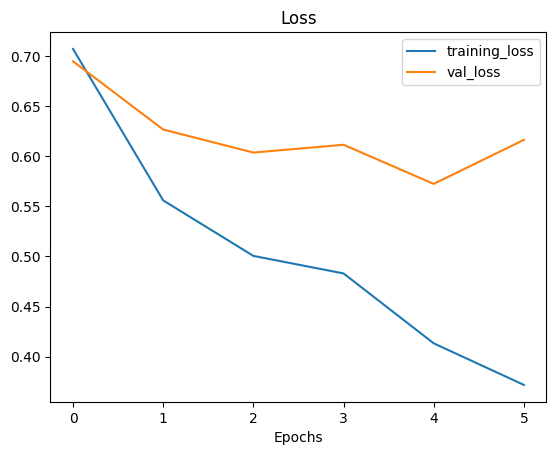

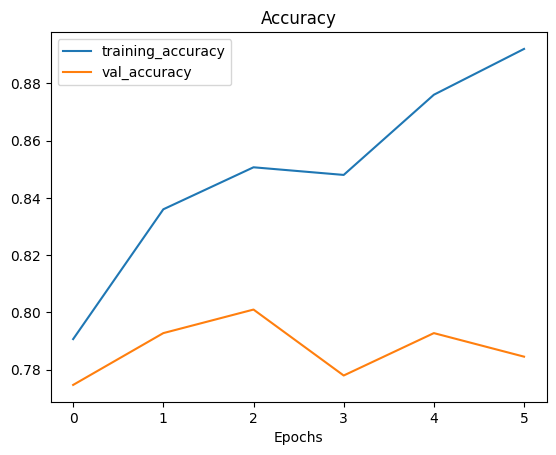

In [496]:
# Check out the loss curves
plot_loss_curves(history_fine_tune_10_percent_data_augmentation)

The `plot_loss_curves` function works great with models which have only been fit once, however, we want something to compare one series of running fit() with another (e.g. before and after fine-tuning).

In [497]:
# Let's create the function to compare training histories
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two TensorFlow model History objects.
    
    Args:
      original_history: History object from original model (before new_history)
      new_history: History object from continued model training (after original_history)
      initial_epochs: Number of epochs in original_history (new_history plot starts from here) 
    """
    
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history metrics with new history metrics
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots for accuracy
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Make plots for loss
    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

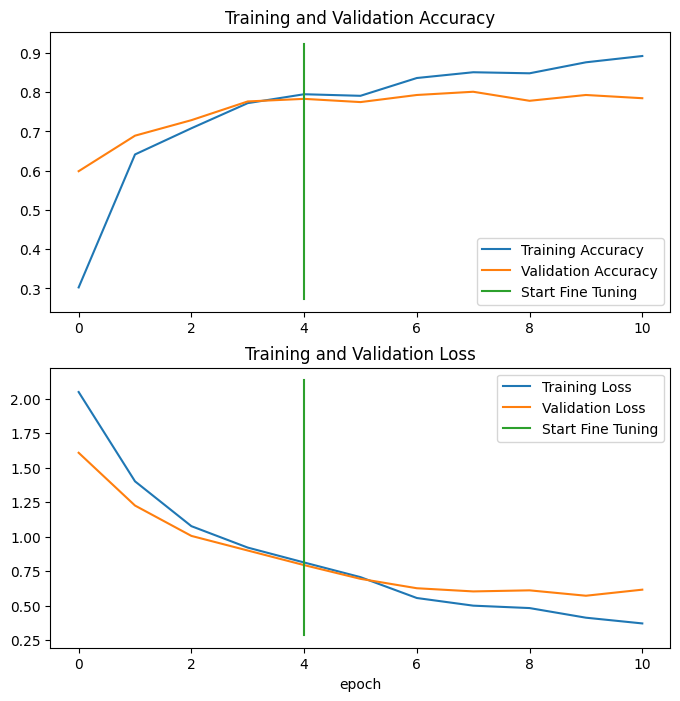

In [498]:
compare_historys(history_10_percent_data_augmentation,history_fine_tune_10_percent_data_augmentation)

## **Model 4: Fine-tuning and existing model on all of the data**

In [499]:
# Download and unzip 10 classes of Food101 data with all images
download_file("https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip", unzip_data=True, delete_zip_data=True)

In [500]:
# Setup training and test dir
train_dir_all_data = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

In [501]:
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 

In [502]:
# Setup data input
import tensorflow as tf
IMG_SIZE = (224,224)

train_data_all_data = tf.keras.utils.image_dataset_from_directory(
                                        directory = train_dir_all_data,
                                        labels='inferred',
                                        label_mode='categorical',
                                        class_names=None,
                                        color_mode='rgb',
                                        batch_size = BATCH_SIZE,
                                        image_size = IMG_SIZE,
                                        shuffle=True,
                                        seed=None,
                                        validation_split=None,
                                        subset=None,
                                        interpolation='bilinear',
                                        follow_links=False,
                                        crop_to_aspect_ratio=False,
                                    )

test_data = tf.keras.utils.image_dataset_from_directory(
                                        directory = test_dir,
                                        labels='inferred',
                                        label_mode='categorical',
                                        class_names=None,
                                        color_mode='rgb',
                                        batch_size = BATCH_SIZE,
                                        image_size = IMG_SIZE,
                                        shuffle=True,
                                        seed=None,
                                        validation_split=None,
                                        subset=None,
                                        interpolation='bilinear',
                                        follow_links=False,
                                        crop_to_aspect_ratio=False,
                                    )

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The test dataset we've loaded in is the same as what we've been using for previous experiments (all experiments have used the same test dataset)

Let's verify this...

In [503]:
# Evaluate model 2 (this is the fine-tuned on 10 percent of data version)
model_2.evaluate(test_data)

79/79 [==============================] - 3s 41ms/step - loss: 0.6188 - accuracy: 0.7936


[0.6187818646430969, 0.7936000227928162]

In [504]:
results_fine_tune_10_percent

[0.6339743733406067, 0.7960000038146973]

To train a fine-tuning (model_4) we need to revert model_2 back to its feature extraction weights.

In [505]:
# Load weights from checkpoint, that way we can fine-tune from 
# the same stage the 10 percent data model was fine-tuned from
model_2.load_weights(checkpoint_path)

In [506]:
model_2.evaluate(test_data)

79/79 [==============================] - 3s 42ms/step - loss: 0.8416 - accuracy: 0.7700


[0.8415966033935547, 0.7699999809265137]

In [507]:
# Check to see if our model_2 has been reverted back to feature extraction results
results_10_percent_data_aug 

[0.8387854695320129, 0.7680000066757202]

Alright, the previous steps might seem quite confusing but all we've done is:

1. Trained a feature extraction transfer learning model for 5 epochs on 10% of the data with data augmentation (model_2) and we saved the model's weights using ModelCheckpoint callback.
2. Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen (model_3).
3. Saved the results and training logs each time.
4. Reloaded the model from step 1 to do the same steps as step 2 except this time we're going to use all of the data (model_4).

In [508]:
# Check which layers are tunable in the whole model
for layer_number, layer in enumerate(model_2.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_2D True
4 output_layer True


In [509]:
# Let's drill into our base_model (efficientnetb0) and see what layers are trainable
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_24 False
1 rescaling_23 False
2 normalization_23 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_re

In [510]:
# Compile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

In [511]:
# Continue to train and fine-tune the model to our data (100% of training data)
fine_tune_epochs = initial_epochs + 5

history_fine_tune_data_all = model_2.fit(train_data_all_data,
                                           epochs=fine_tune_epochs,
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),
                                           initial_epoch=history_10_percent_data_augmentation.epoch[-1],
                                           callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                  experiment_name="fine_tune_data_all")])

Saving TensorBoard log files to: transfer_learning/fine_tune_data_all/20230527-235727
Epoch 5/10
235/235 [==============================] - 13s 49ms/step - loss: 0.7349 - accuracy: 0.7583 - val_loss: 0.5064 - val_accuracy: 0.8339
Epoch 6/10
235/235 [==============================] - 11s 48ms/step - loss: 0.5934 - accuracy: 0.8068 - val_loss: 0.4401 - val_accuracy: 0.8520
Epoch 7/10
235/235 [==============================] - 11s 48ms/step - loss: 0.5327 - accuracy: 0.8304 - val_loss: 0.4007 - val_accuracy: 0.8684
Epoch 8/10
235/235 [==============================] - 11s 47ms/step - loss: 0.4821 - accuracy: 0.8480 - val_loss: 0.4199 - val_accuracy: 0.8635
Epoch 9/10
235/235 [==============================] - 11s 48ms/step - loss: 0.4517 - accuracy: 0.8544 - val_loss: 0.4248 - val_accuracy: 0.8717
Epoch 10/10
235/235 [==============================] - 11s 47ms/step - loss: 0.4175 - accuracy: 0.8655 - val_loss: 0.3313 - val_accuracy: 0.8931


In [512]:
# Let's evaluate on all of the test data
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 3s 40ms/step - loss: 0.3952 - accuracy: 0.8728


[0.3951702117919922, 0.8727999925613403]

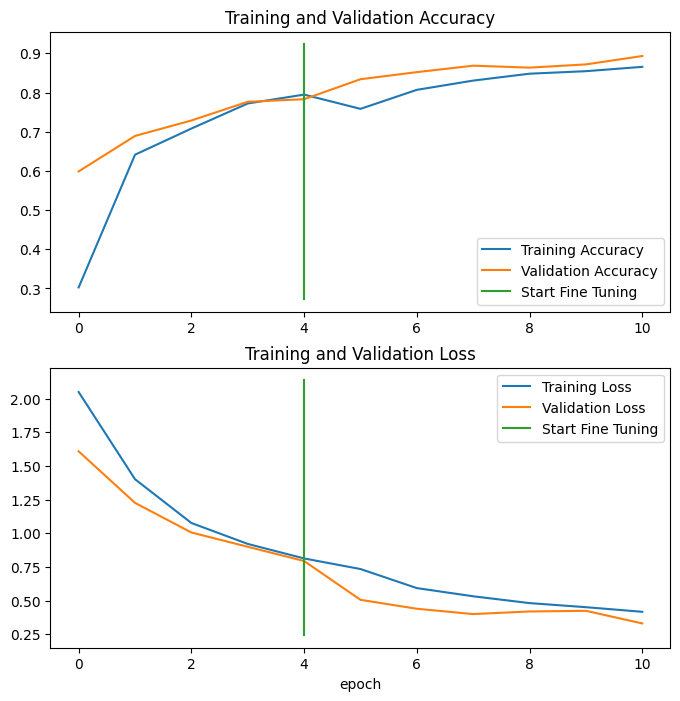

In [513]:
# How did fine-tuning go with more data?
compare_historys(original_history=history_10_percent_data_augmentation,
                 new_history=history_fine_tune_data_all,
                 initial_epochs=5)

## **Viewing our experiment data on TensorBoard**

> 🔑 Note: Anything you upload to TensorBoard.dev is going to be public. So if you have private data, do not upload.

> 🔑 Note: TensorBoard need higher version

Our TensorBoard experiments are uploaded pulically here:https://tensorboard.dev/experiment/j4ELJC4eQduJukHo89rqJg/

In [514]:
# # View tensorboard logs of transfer learning modelling experiments (should ~4 models)
# # Upload TensorBoard dev records
# !tensorboard dev upload --logdir ./transfer_learning \
#   --name "Transfer Learning Experiments with 10 Food101 Classes" \
#   --description "A series of different transfer learning experiments with varying amounts of data and fine-tuning." \
#   --one_shot # exits the uploader once its finished uploading